# Lindbladian calculation of cavity dephasing time 💣

In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tools import proj, params
import csv
from multiprocessing import Pool
from itertools import product
plt.style.use('ggplot')
import IPython
from IPython.core.display import display, HTML
%matplotlib inline
def I(x): return qt.qeye(x)

#### 🔹 Defining parameters

In [2]:
wc       = 0*2*np.pi*0.5e-2   # cavity frequency
# wc=2*np.pi
wa       = 0             # atom frequency
g        = 2*np.pi*0.2   # coupling strength
chi_e    = 2*np.pi*0.05
chi_f    = 2*np.pi*0.1
kappa    = 1e-6          # cavity dissipation rate
gamma    = 0.01          # atom dissipation rate
N        = 5             # number of cavity fock states
qub_lvls = 3
n_th_a   = 0.02          # avg number of atom bath excitation
n_th_c   = 0.01          # avg number of cavity bath excitation
mu       = [1e-3, 1e-3]  # Measurement error rate
# tlist  = params.tlist
tlist = np.linspace(0, 1_000, 10_000)  # MUST: max(tlist) >> 1/chi

#### 🔹 Defining Hamiltonian, initial state and operators

In [3]:
# intial state
cav0  = (qt.basis(N, 1) + qt.basis(N, 0))/np.sqrt(2)
qub0  = qt.basis(qub_lvls, 0)
# psi0  = qt.ket2dm(qt.tensor(cav0, qub0))
psi0  = qt.ket2dm(qt.tensor(cav0, qub0))
psi_e = qt.ket2dm(qt.tensor(cav0, qt.basis(qub_lvls, 1)))

cav1  = (qt.basis(N, 0) - qt.basis(N, 1))/np.sqrt(2)  # |0>-|1>

psi1  = qt.ket2dm(qt.tensor(cav1, qub0))              # |0>-|1> X |g>
psi_1 = qt.ket2dm(qt.tensor(cav1, qt.basis(3,1)))     # |0>-|1> X |e>

# operators
a   = qt.tensor(qt.destroy(N), qt.qeye(qub_lvls))
ad  = a.dag()
sm  = qt.tensor(qt.qeye(N), qt.destroy(qub_lvls))
smd = sm.dag()

# Hamiltonian (no RWA) jayness cummings
# chi_e*|e><e| + chi_f*|f><f| chi_f ~ 2*chi_e
e = qt.tensor(qt.qeye(N), qt.basis(qub_lvls, 1))
ed = e.dag()
f = qt.tensor(qt.qeye(N), qt.basis(qub_lvls, 2))
fd = f.dag()

H = wc*ad*a + wa*smd*sm + ad*a*( chi_e*e*ed + chi_f * f*fd )  # Wc ad*a + Wa |e><e| + ad*a * (chi_e |e><e| + chi_f |f><f|)

In [4]:
def A(j: int, k: int):
    return kappa*n_th_c*np.sqrt(j*k)
def B(j: int, k: int):
    return 1j*(k-j)*(wc+chi_e) - kappa*(n_th_c + 1/2)*(j+k) - kappa*n_th_a
def C(j: int, k: int):
    return kappa*(n_th_c+1)*np.sqrt((j+1)*(k+1))
def D(l):
    if l >= 0:
        j = 0
        k = l
    else:
        j = -l
        k = 0
    
    A_l = np.diag([A(i+j, i+k) for i in range(N-1 - abs(l))],-1)
    B_l = np.diag([B(i+j, i+k) for i in range(N - abs(l))])
    C_l = np.diag([C(i+j, i+k) for i in range(N-1 - abs(l))],1)
    return A_l + B_l + C_l

In [5]:
eigs = np.array([np.linalg.eig(D(l)) for l in range(-N+1, N)])
eigvals = {}
eigvecs = {}
for l in range(-N+1, N):
    eigvals[l] = eigs[N+l-1, 0]
    eigvecs[l] = eigs[N+l-1, 1]

In [74]:
xp = 10_000
x = np.linspace(0,1000000,xp)

c0 = cav0*cav0.dag()  # Initial conditions
c = np.ndarray([xp, N, N], dtype=np.complex128)

# fig, axes = plt.subplots(N,N, figsize=(30,15))

for l in range(-N+1, N):
    s = 0
    i0 = 0 if l>=0 else -l
    j0 = 0 if l<=0 else l
    for i in range(N-abs(l)):
        s += c0[i0+i, j0+i]*(np.reshape(eigvecs[l][i], (1,N-abs(l)))*np.reshape(np.exp(eigvals[l][i]*x), (xp,1)))

    for i in range(N-abs(l)):

        c[:, i0+i, j0+i] = s[:,i]

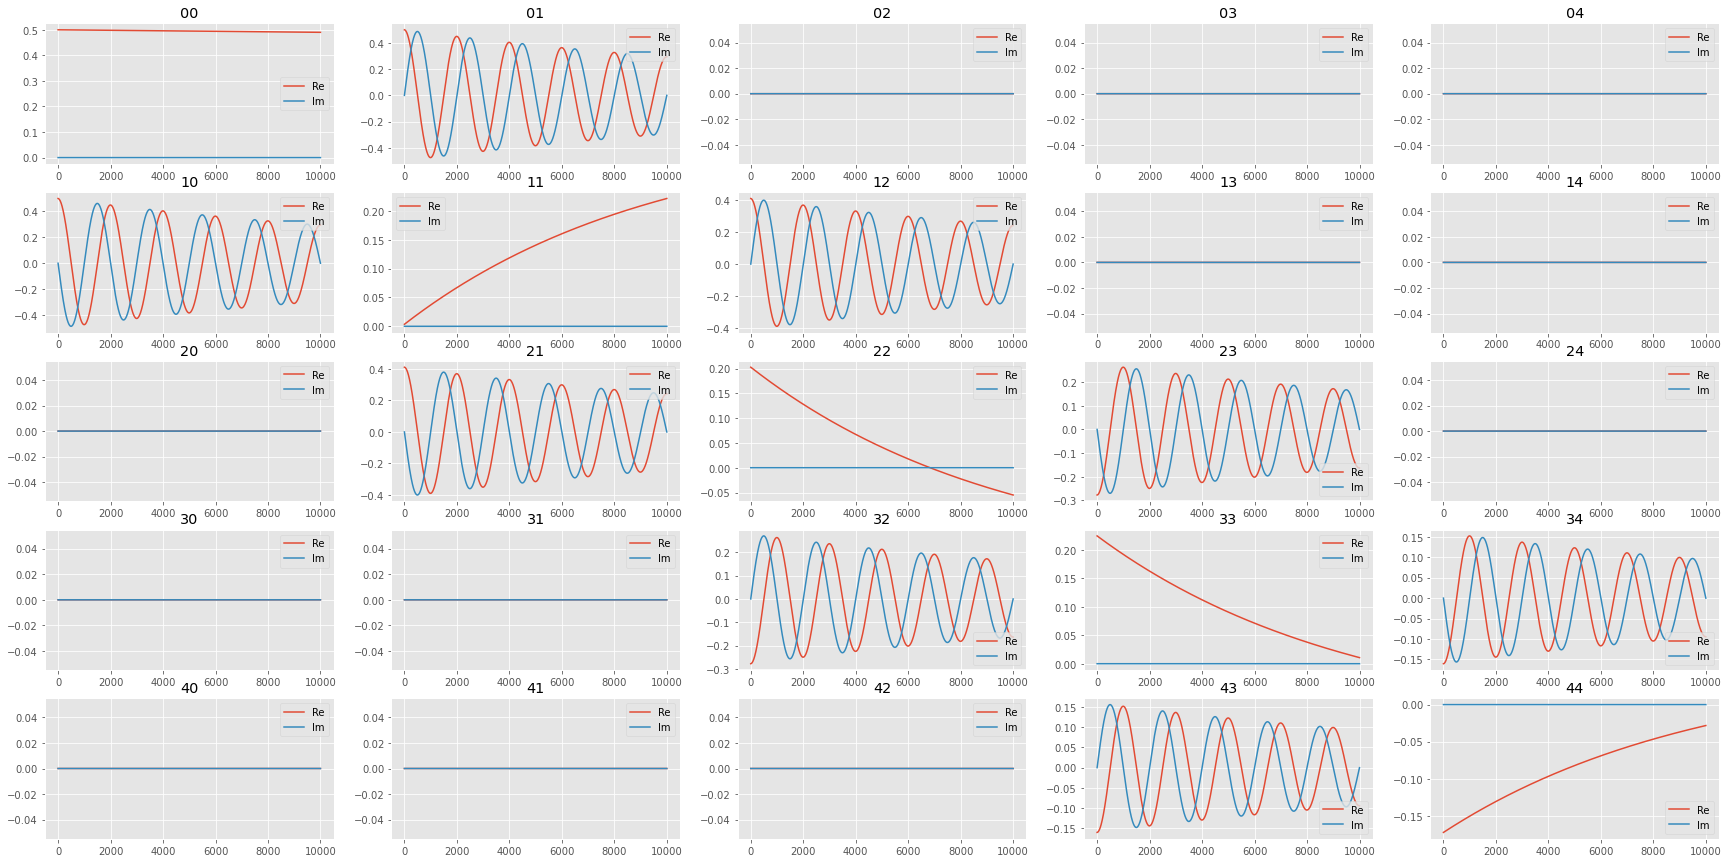

In [78]:
if True:
    fig, axes = plt.subplots(N,N, figsize=(30,15))
    for i in range(N):
        for j in range(N):
            ax = axes[i,j]
            ax.set_title(f'{i}{j}')
            ax.plot(np.real(c[:,i,j]))
            ax.plot(np.imag(c[:,i,j]))
            ax.legend(['Re', 'Im'])

In [51]:
decays = np.array([np.real(eig) for eig in eigs[:,0]])
freqs  = np.array([np.imag(eig) for eig in eigs[:,0]])

### Interesting - The average decay rate is equal for all diagonals 🤔

In [84]:
[-1/(d*1e4) for d in decays]

[array([48.54368932]),
 array([64.51612903, 38.91050584]),
 array([96.15384615, 49.6622683 , 31.98568207]),
 array([188.67924528,  65.98617048,  39.59812664,  27.25420227]),
 array([5000.        ,   98.0391977 ,   49.50230449,   33.00456541,
          23.7529241 ]),
 array([188.67924528,  65.98617048,  39.59812664,  27.25420227]),
 array([96.15384615, 49.6622683 , 31.98568207]),
 array([64.51612903, 38.91050584]),
 array([48.54368932])]

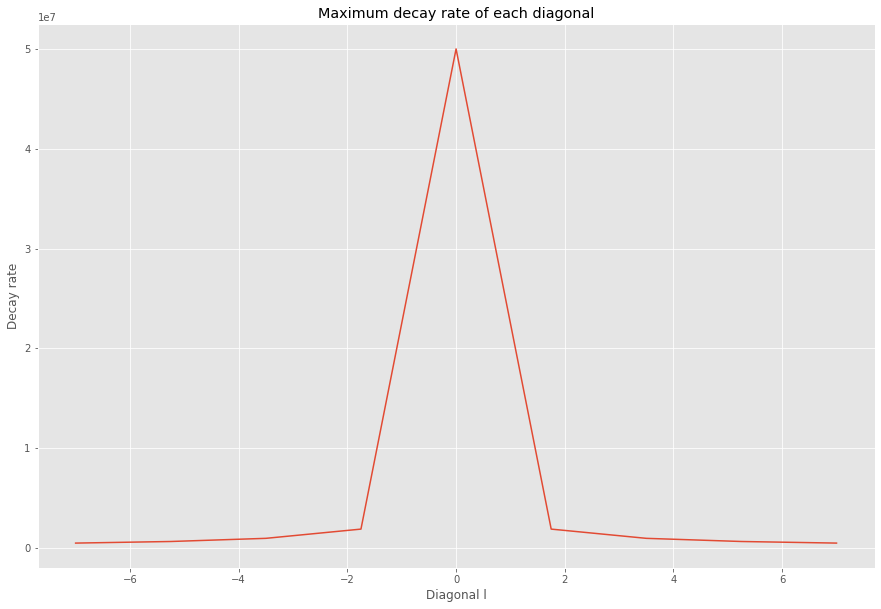

In [52]:
plt.figure(figsize=(15,10))
plt.title('Maximum decay rate of each diagonal')
plt.xlabel('Diagonal l')
plt.ylabel('Decay rate')
plt.plot(np.linspace(-7,7,2*N-1), [-np.min(1/d) for d in decays]);

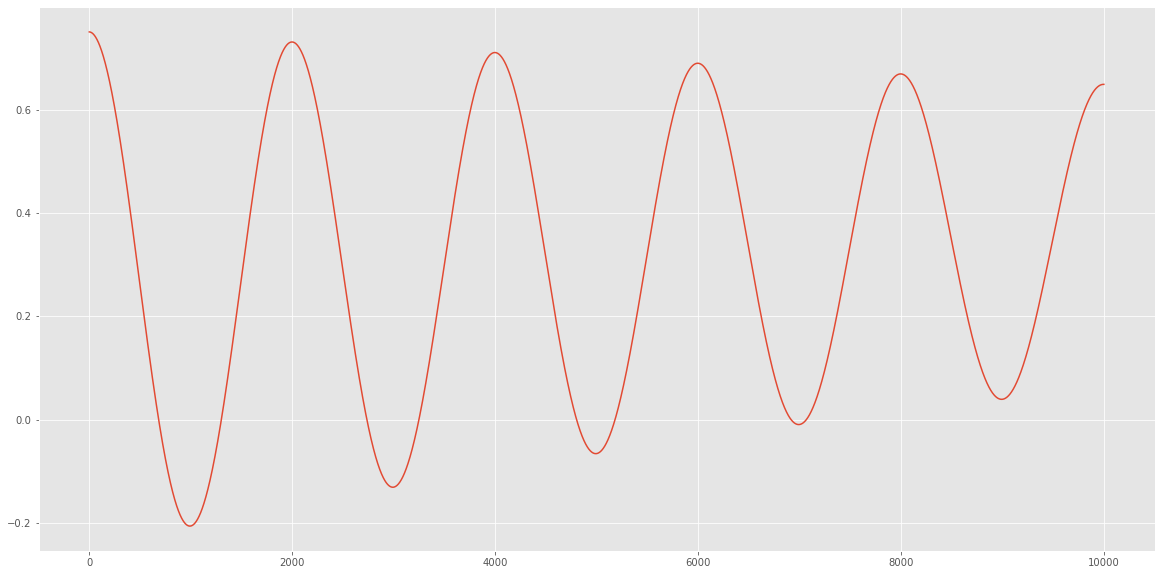

In [53]:
plt.figure(figsize=(20,10))
plt.plot(np.real(np.trace(c@np.reshape(c0, (1,5,5)), axis1=1, axis2=2)))
# plt.plot(np.imag(np.trace(c@np.reshape(c0, (1,5,5)), axis1=1, axis2=2)))

In [55]:
qt.Qobj(c[0])

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = True
Qobj data =
[[ 0.5       +0.00000000e+00j  0.5       +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j]
 [ 0.5       +0.00000000e+00j  0.00351775+0.00000000e+00j
   0.41154011+0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.41154011+0.00000000e+00j
   0.20273622+0.00000000e+00j -0.27713598+4.62594567e-11j
   0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
  -0.27713598-4.62594567e-11j  0.22498473+0.00000000e+00j
  -0.16042986+8.17164027e-21j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j -0.16042986-8.17164027e-21j
  -0.17239706+0.00000000e+00j]]